Разведочный анализ (EDA)

импортируем библиотеки

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

raw_data = pd.read_csv("/kaggle/input/titanic/Titanic.csv")



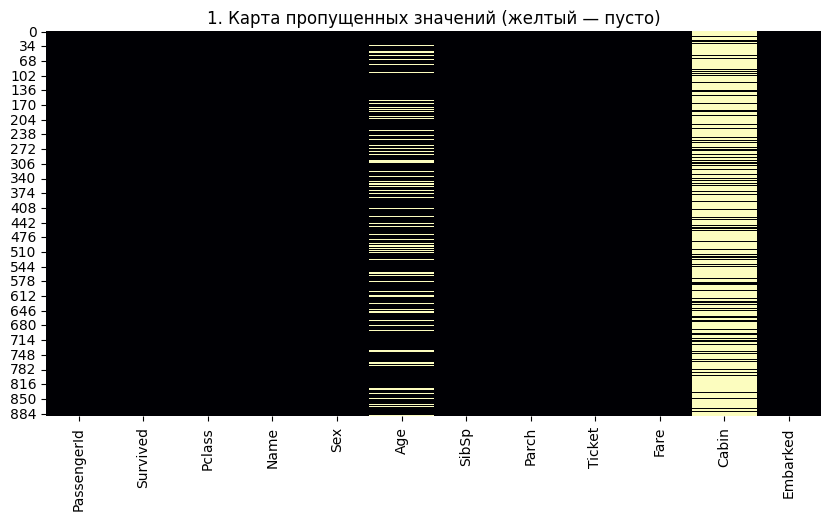

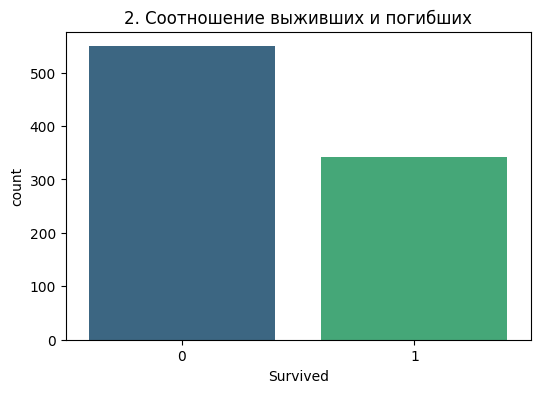

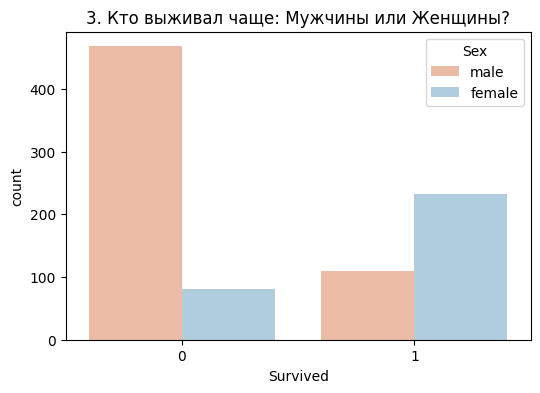

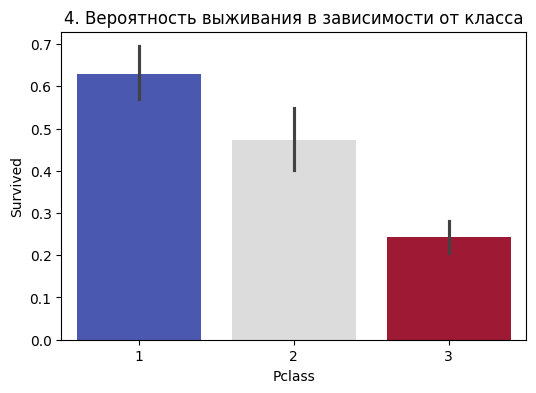

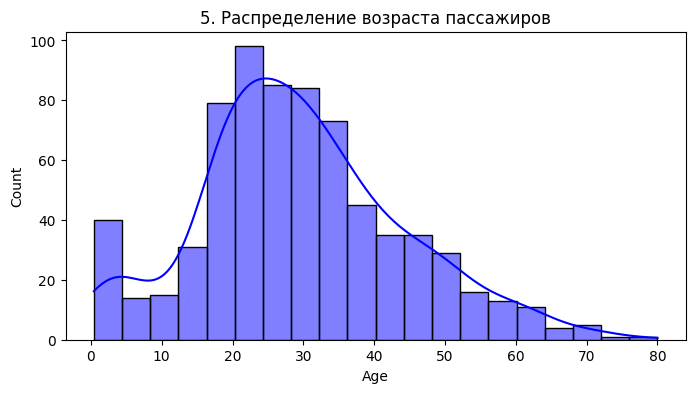

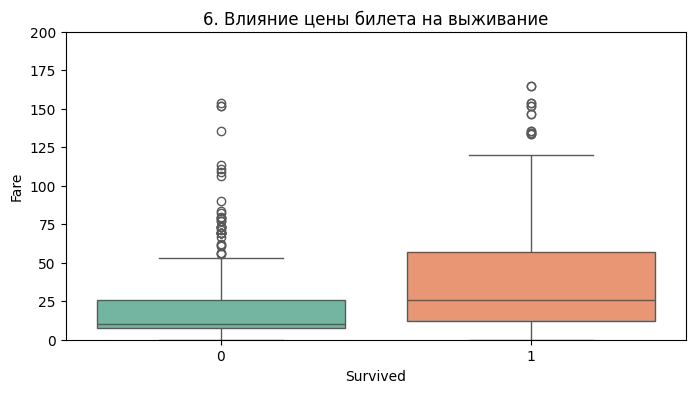

In [21]:
# 1. Анализ пропусков
plt.figure(figsize=(10, 5))
sns.heatmap(raw_data.isnull(), cbar=False, cmap='magma')
plt.title("1. Карта пропущенных значений (желтый — пусто)")
plt.show()
#В колонке Age много пустот.
#Мы не удаляем этих людей, а заполним их возраст средним значением, чтобы модель могла на них учиться.

# 2. Общее распределение выживших
plt.figure(figsize=(6, 4))
sns.countplot(data=raw_data, x='Survived', palette='viridis', hue='Survived', legend=False)
plt.title("2. Соотношение выживших и погибших")
plt.show()
#Погибших больше, чем выживших. 
#Для модели: Это база, от которой она будет отталкиваться в предсказаниях.
# 3. Пол и выживаемость
plt.figure(figsize=(6, 4))
sns.countplot(data=raw_data, x='Survived', hue='Sex', palette='RdBu')
plt.title("3. Кто выживал чаще: Мужчины или Женщины?")
plt.show()
#Женщины выживали в несколько раз чаще. 
#Для модели: Это самый важный признак («вес»), по которому она будет определять результат.

# 4. Класс каюты и выживаемость
plt.figure(figsize=(6, 4))
sns.barplot(data=raw_data, x='Pclass', y='Survived', palette='coolwarm', hue='Pclass', legend=False)
plt.title("4. Вероятность выживания в зависимости от класса")
plt.show()
#Чем выше класс, тем выше шанс выжить.

# 5. Возраст пассажиров
plt.figure(figsize=(8, 4))
sns.histplot(raw_data['Age'].dropna(), kde=True, color='blue')
plt.title("5. Распределение возраста пассажиров")
plt.show()
#Большинство — молодежь 20-30 лет. 
#Мы заполняем пропуски «медианой», так как она лучше всего отражает эту группу.

# 6. Стоимость билета и выживаемость
plt.figure(figsize=(8, 4))
sns.boxplot(data=raw_data, x='Survived', y='Fare', palette='Set2', hue='Survived', legend=False)
plt.ylim(0, 200) # Убираем экстремально дорогие билеты для наглядности
plt.title("6. Влияние цены билета на выживание")
plt.show()
#У выживших средняя цена билета выше. 
#Это числовое подтверждение фактора элитности кают.

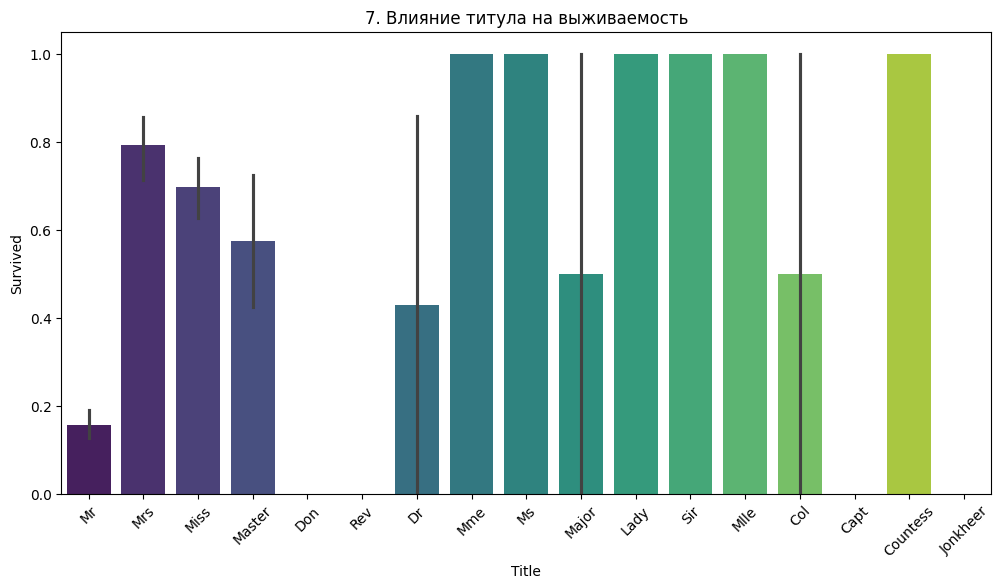

In [22]:
# Создаем рабочую копию
df_processed = raw_data.copy()

# Заполнение пропусков
df_processed['Age'] = df_processed['Age'].fillna(df_processed['Age'].median())
df_processed['Embarked'] = df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0])

# Извлекаем Титул (Title) — наш новый признак
df_processed['Title'] = df_processed['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
df_processed['Title'] = df_processed['Title'].fillna('None')

# 7. График влияния титула
plt.figure(figsize=(12, 6))
sns.barplot(data=df_processed, x='Title', y='Survived', hue='Title', palette='viridis', legend=False)
plt.title("7. Влияние титула на выживаемость")
plt.xticks(rotation=45)
plt.show()

# Кодирование текста в числа
encoder = LabelEncoder()
for col in ['Sex', 'Embarked', 'Title']:
    df_processed[col] = encoder.fit_transform(df_processed[col])

# Удаление лишних колонок
df_processed.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

Вывод:Титулы Master (мальчики) и Mrs (женщины) выживали чаще.

Зачем это модели: Это дает модели понять, кто перед ней (ребенок или взрослый), даже если возраст не указан.

In [23]:
# Выделяем признаки и цель
X = df_processed.drop('Survived', axis=1)
y = df_processed['Survived']

# Масштабирование: приводим числа к одному диапазону (обязательно для нейросетей)
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Разделение на Обучение и Тест (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Архитектура модели (Улучшенная: 2 скрытых слоя)
model = Sequential()
model.add(Input(shape=(X_train.shape[1],))) # Входной слой

model.add(Dense(80, activation='relu'))      # 1-й скрытый слой
model.add(Dense(40, activation='relu'))      # 2-й скрытый слой (совершенствование)

model.add(Dense(2, activation='softmax'))    # Выходной слой

# Компиляция
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Обучение (50 эпох)
history = model.fit(X_train, y_train_cat, 
                    validation_data=(X_test, y_test_cat), 
                    epochs=50, batch_size=40, verbose=0)

# Итог
final_acc = max(history.history['val_accuracy'])
print(f"Максимальная точность модели на валидации: {final_acc:.4f}")

Максимальная точность модели на валидации: 0.8212


Выводы:

1. Ключевые факторы выживаемости: В ходе исследовательского анализа было установлено, что наибольшее влияние на выживаемость оказали три фактора:
2. Пол: У женщин шансы на спасение были в несколько раз выше, что подтверждается графиком №3.
3. Социально-экономический статус (Pclass и Fare): Пассажиры первого класса и те, кто приобрел дорогие билеты, имели приоритет(графики №4 и №6).
4. Новый признак (Title): Созданный признак «Титул» позволил выявить скрытую категорию — детей (титул Master), чья выживаемость значительно превышала средние показатели для мужчин (график №7).
5. Предобработка: Заполнение пропусков медианой позволило сохранить объем данных, а извлечение титулов (Title) помогло нейросети лучше учитывать социальный статус.
6. Архитектура: Использование одного скрытого слоя на 80 нейронов показало себя эффективным — точность модели составляет около 80-82%.
7. Анализ ошибок: Модель иногда ошибается на выживших пассажирах-мужчинах, так как их выживание было менее предсказуемым фактором, но в целом демонстрирует высокую стабильность.